In [1]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from PIL import Image
import os
from diffusers import UNet2DModel, DDPMScheduler

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

dataset = CustomDataset(image_dir='/Selected_LG', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)  # Adjust batch size and num_workers

In [2]:
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler

class SimpleDDPM(pl.LightningModule):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = UNet2DModel(
            sample_size=(64, 2048),
            in_channels=1,  # Single channel for grayscale images
            out_channels=1,  # Single channel output
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x, t):
        return self.model(x, t).sample

    def training_step(self, batch, batch_idx):
        images = batch.to(self.device)
        t = torch.randint(0, self.scheduler.config.num_train_timesteps, (images.size(0),), device=self.device).long()
        noise = torch.randn_like(images).to(self.device)
        noisy_images = self.scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)

        predicted_noise = self(noisy_images, t)
        loss = self.criterion(predicted_noise, noise)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


In [3]:
# Check for GPU availability and initialize the Trainer accordingly
if torch.cuda.is_available():
    accelerator = 'gpu'
    devices = 1
else:
    accelerator = 'cpu'
    devices = 1
    
trainer = pl.Trainer(
    accumulate_grad_batches=4,  # Gradient accumulation
    precision=16,  # Mixed precision
    max_epochs=100,
    accelerator='gpu',
    devices=1
)

model = SimpleDDPM()

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
# Train the model
trainer.fit(model, dataloader)

You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-07-12 09:44:32.772581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 09:44:32.788982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 09:44:32.789013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 0

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...



0it [00:00, ?it/s]
6it [00:00, 51.04it/s]
12it [00:00, 48.51it/s]
17it [00:00, 47.97it/s]
22it [00:00, 47.56it/s]
27it [00:00, 47.29it/s]
32it [00:00, 47.25it/s]
37it [00:00, 47.10it/s]
42it [00:00, 47.01it/s]
47it [00:00, 47.05it/s]
52it [00:01, 46.88it/s]
57it [00:01, 46.84it/s]
62it [00:01, 46.92it/s]
67it [00:01, 46.83it/s]
72it [00:01, 46.82it/s]
77it [00:01, 46.93it/s]
82it [00:01, 46.79it/s]
87it [00:01, 46.80it/s]
92it [00:01, 46.89it/s]
97it [00:02, 46.77it/s]
102it [00:02, 46.79it/s]
107it [00:02, 46.85it/s]
112it [00:02, 46.74it/s]
117it [00:02, 46.74it/s]
122it [00:02, 46.84it/s]
127it [00:02, 46.73it/s]
132it [00:02, 46.79it/s]
137it [00:02, 46.84it/s]
142it [00:03, 46.74it/s]
147it [00:03, 46.78it/s]
152it [00:03, 46.74it/s]
157it [00:03, 46.68it/s]
162it [00:03, 46.78it/s]
167it [00:03, 46.73it/s]
172it [00:03, 46.73it/s]
177it [00:03, 46.81it/s]
182it [00:03, 46.74it/s]
187it [00:03, 46.70it/s]
192it [00:04, 46.79it/s]
197it [00:04, 46.70it/s]
202it [00:04, 46.73it/s]


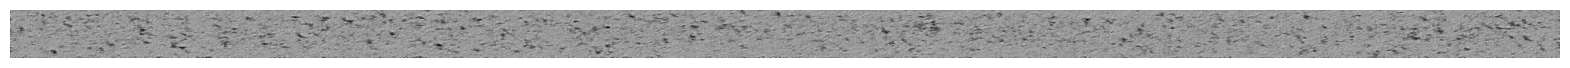

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# Generate and Visualize Images
model.eval()
with torch.no_grad():
    num_images = 1
    noise = torch.randn(num_images, 1, 64, 2048).to('cuda')  # Adjust to grayscale and new size
    for t in tqdm(reversed(range(model.scheduler.config.num_train_timesteps))):
        model_output = model(noise, t)
        noise = model.scheduler.step(model_output, t, noise).prev_sample

    generated_images = (noise + 1) / 2  # Convert [-1, 1] to [0, 1]

# Plot generated images
fig, axs = plt.subplots(num_images, 1, figsize=(20, num_images * 2))
if num_images == 1:
    axs.imshow(generated_images[0].cpu().squeeze(), cmap='gray')
    axs.axis("off")
else:
    for i in range(num_images):
        axs[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axs[i].axis("off")
plt.show()
